## 3.1 クラスタリング
このノートでは**クラスタリング**という教師なし学習の一連の手法群について解説します。

まずクラスタリングとは何かについて説明し、そのアルゴリズムの考え方に応じたクラスタリング手法の大まかな分類として、分割最適型クラスタリングと階層型クラスタリングがあることを説明します。次に、それぞれのクラスタリング手法の代表例として
* 分割最適型クラスタリング：k-means法
* 階層型クラスタリング：ward法

を取り上げ、そのアルゴリズムを解説します。最後に、これらの手法のpros/consについて概要を紹介しましょう。

In [22]:
# 以下で必要なモジュールをimportしておきましょう。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
from yellowbrick.cluster import SilhouetteVisualizer

ModuleNotFoundError: No module named 'yellowbrick'

### A. クラスタリングとは
#### クラスタリングの定義
入力のみを持つデータをもとに、何らかの意味で類似しているデータポイントを1つのクラスターとしてまとめあげる手法があります。この手法の一連をクラスタリングと言います。 出来上がったクラスターには

* 同じクラスターにまとまったデータポイントは類似している。
* 異なるクラスターにまとまったデータポイントは類似していない。

という2つの性質が満たされていることが望ましいと考えられています。以下に、クラスターのイメージを載せておきましょう。
<img src="cluster.png">

**重要な比較** 教師なし学習も、データポイントを入力からカテゴリーを出力する学習器を作りたいと思っている点では教師あり学習の分類問題と変わりません。では、教師あり学習の分類問題との違いはなんでしょうか。それは、学習のために準備する教師データに出力（正解）がついているか否かです。

クラスタリングは入力から類似したデータポイントをなんらかの基準でまとめあげるだけなので、出来上がった学習器の出力が当初欲しいと考えていたラベルになっているとは限りません。（例えば、ウサギの画像から白ウサギか黒ウサギか判定したかったとしても、耳が垂れているかいないかを返す学習器ができるかもしれません。）

教師あり学習の分類問題であれば、学習させる教師データに出力として想定しているラベルを準備しますから、少なくともその点は担保されます。ただし、教師あり学習の場合は出力（正解）を準備するコストがかかるということは忘れないようにしておきましょう。

#### クラスタリングの種類
クラスタリングには大きく分けて、**分割最適型クラスタリング**と**階層型クラスタリング**があります。分割最適型クラスタリングは、事前にクラスタの良さを測る関数を準備しておいて、その関数の値を最小化するようなクラスタリングを求める手法です。一方で、階層型クラスタリングはクラスタを分割したり併合したりすることによってクラスタを階層的に構築する手法です。

また階層型クラスタリングには、さらに**凝集型**と**分割型**があります。凝集型はデータポイント1つ1つをクラスターと考えた状態から始め、類似しているクラスターを逐次的に凝集していく手法です。分割型はデータポイント全体で1つのクラスターと考えた状態から始め、類似していないデータポイント群を逐次的に分割していく手法です。

今回、分割最適型クラスタリングからはk-means法を、階層型クラスタリングからは特に凝集型に分類される最小分散法（Ward法）をメインに紹介します。（今回は分割型の階層型クラスタリングについては紹介しません。）

### B. 分割最適型クラスタリングとk-means法

分割最適型クラスタリングは、事前にクラスタの良さを測る関数を準備しておいて、その関数の値を最小化するようなクラスタリングを求める手法です。今回はk-means法を例に分割最適型クラスタリングを紹介します。

#### B1. k-means法の概要
k-means法はクラスター数$K$を**事前に決めておき**、データポイント全体を$K$個のクラスターに分割する手法の一つです。特にクラスターは
$$L(C_1,\cdots,C_K) = \sum_{k=1}^{n}\sum_{i\in C_k}||x_i-\bar{x}_k||^2$$
が最小になるようなクラスター$C_1,\cdots,C_K$を決定します。なお、各クラスターの重心のことをセントロイドと言います。この最適化問題は一般にNP困難であるため、一般には以下のようなヒューリスティクスによる最適化アルゴリズムが用いられます。

1. ランダムに各データポイントをクラスターに割り振る。
2. 以下の操作を繰り返す。
    - 各クラスターの重心（平均値）を求め、各データポイントからの距離を求める。
    - 各データポイントを最も近い重心に対応するクラスタに振り分け直す。


#### B2. アルゴリズムの各ステップの様子
以下では試しにこのアルゴリズムによるクラスターの更新の様子を見てみましょう。まず、デモデータを次のように生成します。可視化した結果から確認できますが、今回は2次元の散布図上で2群（左下と右上）に分かれているデータを準備しました。

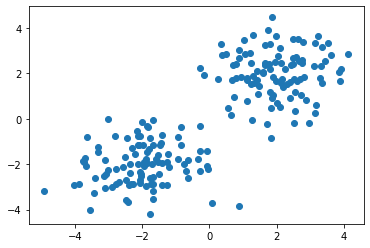

In [5]:
# デモデータの生成
cluster_0 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], 100)
cluster_1 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], 100)
X = np.r_[cluster_0, cluster_1]
 
# 散布図
plt.scatter(X[:,0], X[:,1])
plt.show()

このデータを、クラスター数K=2のk-means法のアルゴリズムによってクラスタリングする様子を見ていきます。

**step 1.** 各データポイントをランダムに2つのクラスターに割り振ります。

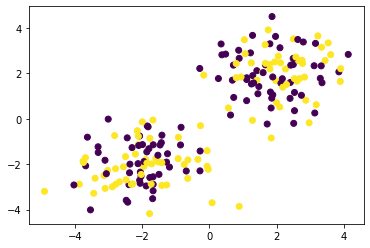

In [6]:
# ランダムにクラスター(culster = 0 or 1)に割り振る
y = np.random.binomial(n = 1, p = 0.5, size = 200)    # 割り振り
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

**step 2.** 各クラスターの重心を計算して、散布図上に図示してみましょう。

In [4]:
center = pd.DataFrame(X, columns = ["X1", "X2"]).assign(y = y).groupby(y).mean()
center

,X1,X2,y
0,0.282180,-0.068309,0
1,-0.137995,-0.091723,1


**step 3.** 各データポイントの重心からの近さを2乗距離で計算します。この結果をもとに各データポイントのクラスターを近いほうの重心に対応するクラスターに更新します。

In [3]:
# クラスターの重心をnumpy配列で抽出する。
center_cluster_0 = center.loc[0, ["X1", "X2"]].values
center_cluster_1 = center.loc[1, ["X1", "X2"]].values

# 各データポイントについてクラスターからの2乗距離を計算する。
dist_cluster_0 = (X[:, 0].reshape(200) - center_cluster_0[0])**2 + (X[:, 1].reshape(200) - center_cluster_0[1])**2
dist_cluster_1 = (X[:, 0].reshape(200) - center_cluster_1[0])**2 + (X[:, 1].reshape(200) - center_cluster_1[1])**2
new_cluster_id = dist_cluster_0 < dist_cluster_1

# 可視化
plt.scatter(X[:,0], X[:,1], c = new_cluster_id)
plt.show()

NameError: name 'center' is not defined

どうでしょう。綺麗に2つのクラスターにまとまったのではないでしょうか。実際にはこんなに早くクラスターがまとまるわけではないので、重心の計算・クラスターの更新を繰り返すことでクラスターをまとめていきます。

#### B3. Pythonによる実習
#### 前処理
Pythonでk-means法を実際にやってみましょう。world.pngは地球全体の夜を写した衛星写真です。
<img src="world.png">

画像は実を言うと、輝度やRGBの度合いを表す数値が各ピクセルに書かれている配列（これをチャネルという）の集まりです。例えば、pngファイルのチャネルはRGBとalphaの4つからなります。RGBは赤緑青の濃さ、alphaはその画像の不透明度です。この配列を入力にして、画像の各ピクセルをクラスタリングするとどうなるかやってみましょう。

In [10]:
# 画像の読み込み
im = np.array(Image.open("world.png"))
im.shape

(446, 893, 4)

In [11]:
X = im.reshape(446 * 893, 4)
X.shape

(398278, 4)

#### sklearnによるk-means学習器の実装
入力$X$のデータからk-means学習器を学習させてみましょう。k-means学習器は`KMeans`というクラス名で`sklearn.cluster`モジュールに含まれています。
* fitメソッド：学習
* predictメソッド：予測クラスターを計算する。

`n_clusters`引数でクラスター数、`max_iter`引数でアルゴリズムの繰り返し数を指定します。

In [12]:
kmeans = KMeans(n_clusters = 3, max_iter = 100)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [13]:
cluster_kmeans = kmeans.predict(X)
cluster_kmeans

array([0, 0, 0, ..., 0, 0, 0])

#### 結果の確認
さて、計算結果を画像に反映させて確認してみましょう。

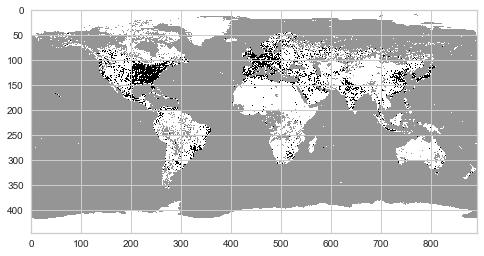

In [14]:
im_cluster = cluster_kmeans.reshape(446, 893)
plt.imshow(im_cluster)
plt.show()

### B4. k-means法のpros/cons
k-means法は他のクラスタリング手法に比べて、データポイントの数に対してスケールするという性質が知られています。そのため、他のクラスタリング手法と比較して最初に試される手法です。

一方で、k-means法には2つの注意点があります。1つはデータを標準化しておく必要性、もう一つは各クラスターのサンプルサイズの不均一性に対する弱さです。

#### 標準化の必要性
k-means法のアルゴリズムは距離に依存しているので、ある変数の値が10倍されると、クラスタリングの結果がその変数に引っ張られてしまいます。実際に、以下のスクリプトを実行してみてください。

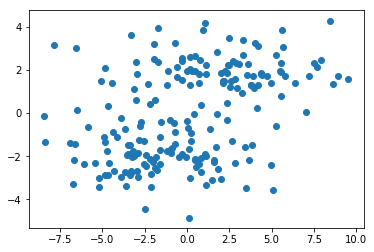

In [11]:
# デモデータの生成
cluster_0 = np.random.multivariate_normal([-2, -2], [[10, 0], [0, 1]], 100)
cluster_1 = np.random.multivariate_normal([2, 2], [[10, 0], [0, 1]], 100)
X = np.r_[cluster_0, cluster_1]
 
# 散布図
plt.scatter(X[:,0], X[:,1])
plt.show()

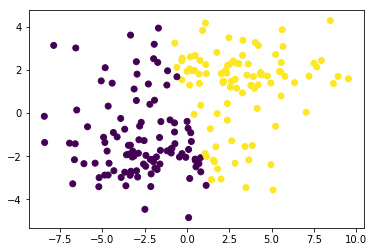

In [12]:
# k-means法によるクラスタリング
kmeans = KMeans(n_clusters = 2, max_iter = 100)
kmeans.fit(X)
cluster_kmeans = kmeans.predict(X)
plt.scatter(X[:,0], X[:,1], c = cluster_kmeans)
plt.show()

#### サンプルサイズの不均一性
また、k-means法は各データポイントのサンプルサイズがおおよそ同じであるという仮定を暗に置いています。実際、以下のスクリプトを実行してみてください。

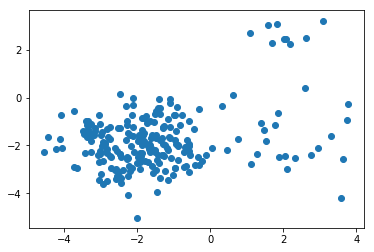

In [13]:
# デモデータの生成
cluster_0 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], 200)
cluster_1 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], 10)
cluster_2 = np.random.multivariate_normal([2, -2], [[1, 0], [0, 1]], 20)
X = np.r_[cluster_0, cluster_1, cluster_2]
 
# 散布図
plt.scatter(X[:,0], X[:,1])
plt.show()

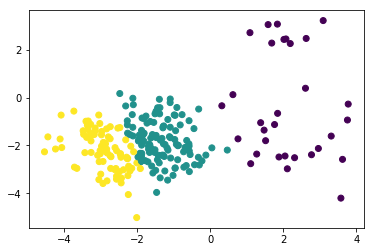

In [14]:
# k-means法によるクラスタリング
kmeans = KMeans(n_clusters = 3, max_iter = 100)
kmeans.fit(X)
cluster_kmeans = kmeans.predict(X)
plt.scatter(X[:,0], X[:,1], c = cluster_kmeans)
plt.show()

### C. 階層型クラスタリング
階層型クラスタリングは、クラスタを分割したり併合したりすることによってクラスタを階層的に構築する手法で、主に**凝集型**と**分割型**の2種類があります。凝集型はデータポイント1つ1つをクラスターと考えた状態から始め、類似しているクラスターを逐次的に凝集していく手法です。分割型はデータポイント全体で1つのクラスターと考えた状態から始め、類似していないデータポイント群を逐次的に分割していく手法です。

今回は凝集型クラスタリングについて説明し、特にWard法と群平均法について説明します。（Ward法の説明のために最短距離法と重心法も紹介します。）

#### C1. 凝集型階層クラスタリングの概要
凝集型階層クラスタリングでは、事前に2つのクラスター$C,C'$のクラスター間距離$d(C,C')$を1つ指定して、以下のステップを繰り返します。なお、クラスター間距離には様々な種類があるのですが、以下で紹介するWard法を使うのが一般的です。
1. 各データポイント一つ一つをクラスターとみなした状態からスタートする。
2. 最初は全てのクラスター間の距離を計算する。
3. 以下の計算を繰り返す。
    - 最も近接している2つのクラスター$C, C'$をみつけて併合する。
    - 新しく作ったクラスターと既存のクラスターとの距離を計算する。
4. データポイントすべてが1つのクラスターとしてまとまったらこの計算を終了する。

ところで、最も隣接している2つのクラスターを見つけるためには、クラスター間距離をすべて知っておく必要があるのですが、step 3の2項目では新しく作ったクラスターに対してしかこの計算を行っていません。実はこれは**時間計算量**の観点から重要なアイディアです。

step 2で既存のクラスター間距離はすでに計算していますから、実は改めて既存のクラスター間でその距離を計算しなくてもその値は保存できます。そして仮に計算したとすると、そのときのクラスター数の2乗に比例してクラスター間距離の計算量が増えることがわかるでしょう。新しく作ったクラスターに対してだけであれば時間計算量はクラスター数の1乗分で済みます。

#### C2. デンドログラム
凝集型階層クラスタリングの結果を可視化する方法としてデンドログラムがあります。デンドログラムは、縦軸をクラスター間距離として、各クラスターの併合の様子を木で表現します。

#### C3. Ward法
Ward法の距離は、クラスター$C,C'$との距離を併合後の分散と併合前の分散の和の差で表現する手法です。要するに、Ward法は併合しても分散があまり変化しないような2つのクラスターを併合します。
$$d(C,C') = Var[C\cup C']-(Var[C]+Var[C'])$$
分散分析で2つの群に有意な差があるとはどういう状況を指すことだったかを思い出すと、この気持ちが分かるかもしれません。

Ward法には、以下の性質が知られています。
* 外れ値に強い。
* その定義からユークリッド距離の2乗でデータポイント間の近さを測っている。→ データの標準化が必要。
* 球状のクラスターが作られやすい。

#### C4. Pythonによる実習
#### 前処理
各国を乳製品の消費量からクラスタリングしてみましょう。データを読み込んで、分布の様子を散布図で事前に確認しておきます。

In [7]:
data = pd.read_csv("dairy_products.csv")
data.head(5)

,country,butter,milk,cheese
0,中国,0.1,20.3,0.1
1,日本,0.6,30.8,2.4
2,韓国,0.2,32.9,2.8
3,イラン,1.0,27.1,4.7
4,トルコ,0.9,17.8,7.8


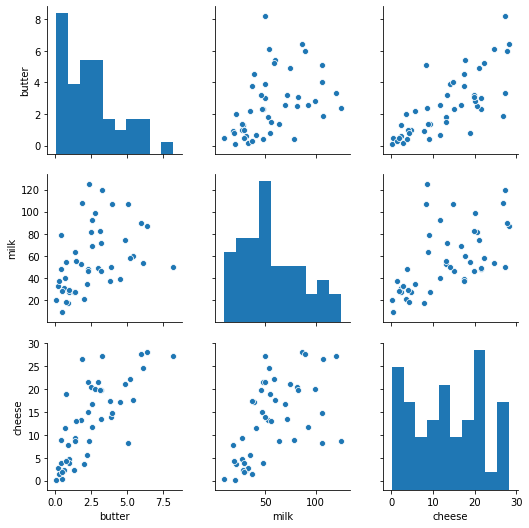

In [8]:
sns.pairplot(data)

入力に各項目の標準偏差の違いが見受けられます。Ward法は各変数の標準偏差の影響を受けるため、事前にデータを標準化しておきます。

In [9]:
# 入力の2次元配列を作る。
X = data.drop("country", axis = 1).values
X.shape

(46, 3)

In [12]:
# データを標準化する。
from sklearn.preprocessing import MinMaxScaler
MM = MinMaxScaler()
X_scaled = MM.fit_transform(X)

In [13]:
# あとで必要になるので、各データポイントのラベルを1次元配列で準備する。
country = data["country"].values

#### scipyによる凝集型階層クラスタリングの実装
凝集型階層クラスタリングは'sklearn'パッケージでも可能ですが、デンドログラムを書きづらいという難点があるので、今回はより使いやすい'scipy'パッケージの`cluster`モジュールにある`hierarchy`サブモジュールから`linkage`関数, `dendrogram`関数, `fcluster`関数を紹介します。

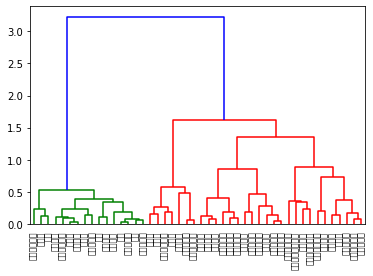

In [25]:
# 凝集型階層クラスタリングの計算と結果
result = linkage(X_scaled, method = "ward")
dendrogram(result, labels = country)
plt.show()

In [15]:
# クラスターの計算
cluster = fcluster(result, t = 1.0, criterion = "distance")
cluster

array([1, 1, 1, 1, 1, 3, 1, 1, 4, 2, 3, 2, 3, 3, 4, 3, 4, 2, 4, 2, 3, 2,
       3, 3, 3, 4, 3, 3, 4, 4, 1, 4, 1, 1, 1, 1, 3, 1, 1, 2, 4, 2, 1, 1,
       4, 4], dtype=int32)

#### 結果の確認と評価

In [29]:
# 結果の確認（クラスター1）
data = data.assign(cluster = cluster)
data.query("cluster == 1")

,country,butter,milk,cheese,cluster
0,中国,0.1,20.3,0.1,1
1,日本,0.6,30.8,2.4,1
2,韓国,0.2,32.9,2.8,1
3,イラン,1.0,27.1,4.7,1
4,トルコ,0.9,17.8,7.8,1
6,カザフスタン,1.3,27.5,2.4,1
7,モンゴル,0.5,9.1,0.3,1
30,メキシコ,1.0,29.2,3.9,1
32,ブラジル,0.4,48.2,3.8,1
33,コロンビア,0.3,36.9,1.4,1


In [17]:
# クラスターの特徴
data.groupby("cluster").mean()

,butter,milk,cheese
cluster,,,
1,0.868750,28.081250,4.118750
2,6.028571,67.571429,24.085714
3,2.408333,51.700000,15.783333
4,3.045455,96.618182,17.054545


In [18]:
# クラスターの特徴
data.groupby("cluster").std()

,butter,milk,cheese
cluster,,,
1,0.606321,9.593277,3.165695
2,1.096531,16.202542,3.953660
3,1.292255,11.101269,4.386722
4,0.877911,18.696033,6.508973


/Users/kitagawatakayuki/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/kitagawatakayuki/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


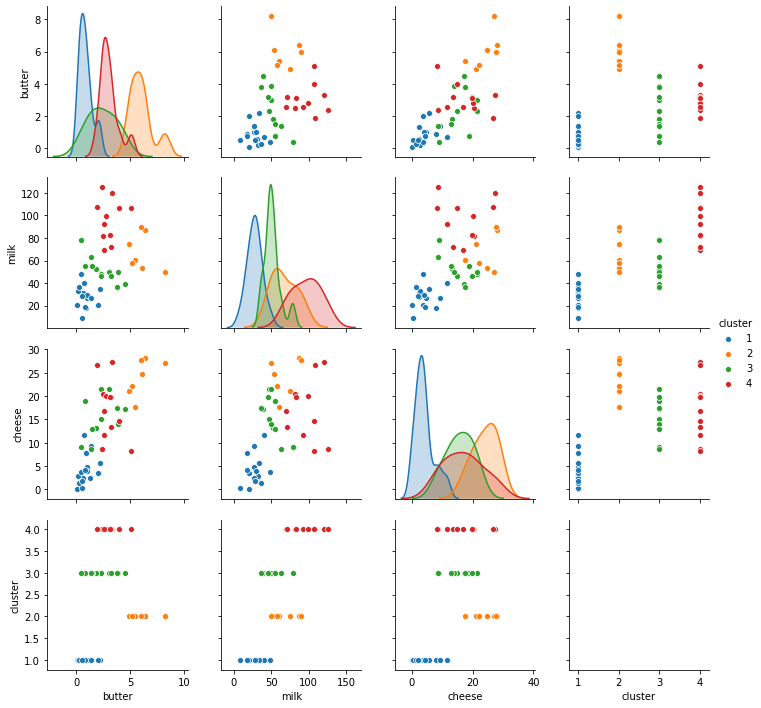

In [19]:
# 散布図で確認
sns.pairplot(data, hue = "cluster")
plt.show()

クラスター1, 2, 3はそれぞれ牛乳を消費する量の大きさに依存して3段階のクラスターが出来ている。一方で、クラスター4は全般的に乳製品を消費しない傾向にある国がまとまっている。

In [20]:
# cophenetic相関係数
distance = pdist(X_scaled)
cophenet(result, distance)

(0.6718555707932139,
 array([0.33300798, 0.33300798, 0.38548418, ..., 3.22917775, 3.22917775,
        0.33648825]))

#### C5. 凝集型階層クラスタリングに求められる解釈可能性
凝集型階層クラスタリングでは、**空間拡散**という性質と**距離の単調性**が要求されるのが一般的です。空間拡散とは、一度併合して作ったクラスターはその後併合されづらくなるという性質です。距離の単調性はクラスターの併合が行われるごとにクラスター間距離の最小値が大きくなっていくことです。この2つの現象は、クラスタリングの結果の解釈可能性を損なうきっかけになります。これを2つの例で説明しましょう。

#### 空間拡散
空間拡散の性質を持たないクラスター間距離に最短距離法があります。最短距離法は各クラスター間のデータポイント間の距離の最小値をクラスター間距離とする手法です。このとき、デンドログラムが鎖状構造を持ちやすいことが知られています。

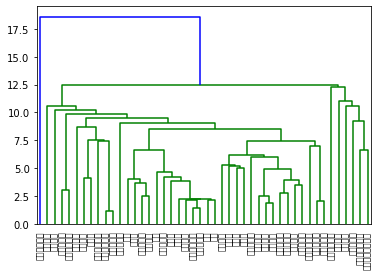

In [24]:
# 凝集型階層クラスタリングの計算と結果
result = linkage(X, method = "single")
dendrogram(result, labels = country)
plt.show()

#### 単調性
距離の単調性を持たないクラスター間距離に重心法があります。重心法は、クラスターの重心間の距離をクラスター間距離とする方法です。このとき、デンドログラムが交差する現象が起こりやすいことが知られています。

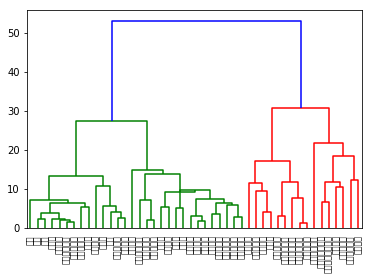

In [26]:
# 凝集型階層クラスタリングの計算と結果
result = linkage(X, method = "centroid")
dendrogram(result, labels = country)
plt.show()

主にward法が凝集型クラスタリングで多用されるのは、このような問題がward法では起こらないことが知られているためです。

### D. おわりに（pros/cons）
今回はクラスタリング手法、特に分割最適型クラスタリングと階層型クラスタリングを紹介しました。ところで、この2つの手法はどのように使い分ければよいのでしょうか。

鍵になるのは時間計算量が重要か各データポイント間の近さまで必要かという視点です。分割型クラスタリングは時間計算量は軽いですが、各データポイントの近さを可視化することは出来ません。一方で階層型クラスタリングは時間計算量はややかかるものの、各データポイントの近さまで見ることが出来ます。

データの様子が分かってきたら、他の発展的なクラスタリングを試してみるのがよいでしょう。例えば、EMアルゴリズムやDBSCAN、BIRCHなどといった手法があるので調べてみてください。